Create the Service Account in your GCP project.
Generate a JSON key file. 

In [75]:
GCP_PROJECT_NAME='ob-google-analytics'
SERVICE_ACCOUNT_NAME='ob-google-analytics-sa'
SERVICE_ACCOUNT_ID='ob-google-analytics-sa'
SERVICE_ACCOUNT_EMAIL_ADDR='ob-google-analytics-sa@valued-vault-419517.iam.gserviceaccount.com'

# https://developers.google.com/analytics/devguides/reporting/data/v1/api-schema#metrics
GA_METRICS = [
    'activeUsers', 
    # 'active7DayUsers',
    # 'active28DayUsers',
    # 'newUsers',
    'averageSessionDuration',
    # 'engagedSessions',
    'engagementRate',
    'bounceRate',
    'sessions', 
    # 'sessionsPerUser',
    # 'organicGoogleSearchClicks',
    # 'dauPerWau',
    # 'dauPerMau',
    # 'wauPerMau',
]
 
# https://developers.google.com/analytics/devguides/reporting/data/v1/api-schema#dimensions
GA_DIMENSIONS = [
    # 'audienceId',
    'browser',
    'city',
    'region',
    'country',
    # 'contentId',
    'dateHourMinute',
    # 'dayOfWeekName',
    'deviceCategory',
    # 'deviceModel',
    'eventName',
    'fullPageUrl',
    # 'googleAdsKeyword',
    # 'googleAdsQuery',
    'landingPage',
    # 'language',
    # 'mobileDeviceBranding',
    # 'mobileDeviceMarketingName',
    # 'mobileDeviceModel',
    # 'operatingSystemWithVersion',
    # 'pageTitle',
    # 'region',
    # 'searchTerm',
    # 'userAgeBracket',
    # 'userGender'
]

GA_START_DATE, GA_END_DATE = '2daysAgo', 'yesterday'
GA_KEY_FILE_LOCATION = 'credentials.json'
GA_SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
GA_PROPERTY_ID = "300797527"

GA_REQUEST_LIMIT = 100_000

## Make the API calls

https://developers.google.com/analytics/devguides/reporting/data/v1

In [116]:
from google.analytics.data_v1beta.types import DateRange, Dimension, Metric, RunReportRequest
from google.analytics.data_v1beta import BetaAnalyticsDataClient

from tqdm.notebook import tqdm
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [77]:
%env GOOGLE_APPLICATION_CREDENTIALS=/Users/eddie/Dev/dbt-snowflake-metaflow/notebooks/credentials.json

env: GOOGLE_APPLICATION_CREDENTIALS=/Users/eddie/Dev/dbt-snowflake-metaflow/notebooks/credentials.json


In [79]:
client = BetaAnalyticsDataClient()

In [80]:
request = RunReportRequest(
    property=f"properties/{GA_PROPERTY_ID}",
    dimensions=[Dimension(name=dimension_name) for dimension_name in GA_DIMENSIONS],
    metrics=[Metric(name=metric_name) for metric_name in GA_METRICS],
    date_ranges=[DateRange(start_date=GA_START_DATE, end_date=GA_END_DATE)],
    limit=GA_REQUEST_LIMIT,
)
response = client.run_report(request)

In [81]:
row_id = 75
d = dict(zip(GA_DIMENSIONS, [v.value for v in response.rows[row_id].dimension_values])) 
d |= dict(zip(GA_METRICS, [v.value for v in response.rows[row_id].metric_values]))
d

{'browser': 'Chrome',
 'city': 'Paris',
 'region': 'Ile-de-France',
 'country': 'France',
 'dateHourMinute': '202404060404',
 'deviceCategory': 'desktop',
 'eventName': 'first_visit',
 'fullPageUrl': 'outerbounds.com/',
 'landingPage': '/',
 'activeUsers': '2',
 'averageSessionDuration': '0',
 'engagementRate': '0',
 'bounceRate': '1',
 'sessions': '2'}

In [82]:
data = []
for row in tqdm(response.rows):
    d = dict(zip(GA_DIMENSIONS, [v.value for v in row.dimension_values])) 
    d |= dict(zip(GA_METRICS, [v.value for v in row.metric_values]))
    data.append(d)

  0%|          | 0/2691 [00:00<?, ?it/s]

In [83]:
df = pd.DataFrame(data)

In [84]:
now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['api_query_date'] = [now] * df.shape[0]

if GA_START_DATE.endswith('daysAgo'):
    _start_date = datetime.now() - pd.Timedelta(GA_START_DATE.replace('daysAgo', 'days'))
else:
    _start_date = GA_START_DATE

if GA_END_DATE.endswith('daysAgo'):
    _end_data = datetime.now() - pd.Timedelta(GA_END_DATE.replace('daysAgo', 'days'))
else:
    _end_data = GA_END_DATE

df['api_query_start_date'] = [_start_date] * df.shape[0]
df['api_query_end_date'] = [_end_data] * df.shape[0]

2024-04-06 09:56:39.437507


In [86]:
df.sample(5)

,browser,city,region,country,dateHourMinute,deviceCategory,eventName,fullPageUrl,landingPage,activeUsers,averageSessionDuration,engagementRate,bounceRate,sessions,api_query_date
1770,Chrome,Tucker,Georgia,United States,202404062032,mobile,first_visit,outerbounds.com/blog/announcing-full-stack-ml-...,/blog/announcing-full-stack-ml-courses,1,0,0,1,1,2024-04-08 09:56:39
1314,Chrome,Nuremberg,Bavaria,Germany,202404070012,desktop,page_view,outerbounds.com/get-started/,/,1,2.885029,1,0,1,2024-04-08 09:56:39
265,Chrome,Amsterdam,North Holland,Netherlands,202404060402,desktop,page_view,outerbounds.com/,/,1,0,0,1,1,2024-04-08 09:56:39
2406,Safari,San Jose,California,United States,202404061524,mobile,page_view,outerbounds.com/docs/data-science-welcome/,/docs/data-science-welcome,1,0,1,0,1,2024-04-08 09:56:39
1171,Chrome,Martinez,California,United States,202404071936,mobile,page_view,outerbounds.com/work-with-us/?ashby_jid=7b2db3...,/blog/metaflow-dynamic-cards,1,5.080002,1,0,1,2024-04-08 09:56:39


## Analysis

In [87]:
df.columns

Index(['browser', 'city', 'region', 'country', 'dateHourMinute',
       'deviceCategory', 'eventName', 'fullPageUrl', 'landingPage',
       'activeUsers', 'averageSessionDuration', 'engagementRate', 'bounceRate',
       'sessions', 'api_query_date'],
      dtype='object')

In [88]:
df.dtypes

browser                   object
city                      object
region                    object
country                   object
dateHourMinute            object
deviceCategory            object
eventName                 object
fullPageUrl               object
landingPage               object
activeUsers               object
averageSessionDuration    object
engagementRate            object
bounceRate                object
sessions                  object
api_query_date            object
dtype: object

In [89]:
# update numerical types
df['activeUsers'] = df['activeUsers'].astype(int)
df['averageSessionDuration'] = df['averageSessionDuration'].astype(float)
df['engagementRate'] = df['engagementRate'].astype(float)
df['bounceRate'] = df['bounceRate'].astype(float)
df['sessions'] = df['sessions'].astype(int)

In [90]:
# 
df.deviceCategory.value_counts()

deviceCategory
desktop    2009
mobile      663
tablet       19
Name: count, dtype: int64

In [91]:
df[df.country == 'Austria']

,browser,city,region,country,dateHourMinute,deviceCategory,eventName,fullPageUrl,landingPage,activeUsers,averageSessionDuration,engagementRate,bounceRate,sessions,api_query_date
1794,Chrome,Vienna,Vienna,Austria,202404060233,desktop,first_visit,outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-08 09:56:39
1795,Chrome,Vienna,Vienna,Austria,202404060233,desktop,page_view,outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-08 09:56:39
1796,Chrome,Vienna,Vienna,Austria,202404060233,desktop,session_start,outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-08 09:56:39
1797,Chrome,Vienna,Vienna,Austria,202404060234,desktop,first_visit,outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-08 09:56:39
1798,Chrome,Vienna,Vienna,Austria,202404060234,desktop,page_view,outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-08 09:56:39
1799,Chrome,Vienna,Vienna,Austria,202404060234,desktop,session_start,outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-08 09:56:39
1800,Chrome,Vienna,Vienna,Austria,202404060303,desktop,first_visit,outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-08 09:56:39
1801,Chrome,Vienna,Vienna,Austria,202404060303,desktop,page_view,outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-08 09:56:39
1802,Chrome,Vienna,Vienna,Austria,202404060303,desktop,session_start,outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-08 09:56:39
1803,Chrome,Vienna,Vienna,Austria,202404060333,desktop,first_visit,outerbounds.com/,/,1,0.000000,0.0,1.0,1,2024-04-08 09:56:39


In [99]:
df[df.averageSessionDuration > 1000].groupby('fullPageUrl').sessions.sum().sort_values(ascending=False)

fullPageUrl
outerbounds.com/                                                                        4
outerbounds.com/docs/use-artifacts-in-join-step/                                        2
outerbounds.com/docs/nlp-tutorial-L1/                                                   1
outerbounds.com/metaflow/                                                               1
outerbounds.com/features/cloud-workstations/                                            1
outerbounds.com/features/access-data/                                                   1
outerbounds.com/engineering/service-architecture/                                       1
outerbounds.com/engineering/deployment/aws-managed/introduction/                        1
outerbounds.com/engineering/deployment/aws-managed/cloudformation/                      1
outerbounds.com/docs/nlp-tutorial-overview/                                             1
outerbounds.com/docs/nested-foreach/                                                    

In [100]:
df.eventName.value_counts()

eventName
page_view                   949
session_start               632
first_visit                 456
user_engagement             355
scroll                      222
click                        61
request_demo_pageview         8
sandbox_btn_clicks            4
request_demo_submissions      4
Name: count, dtype: int64

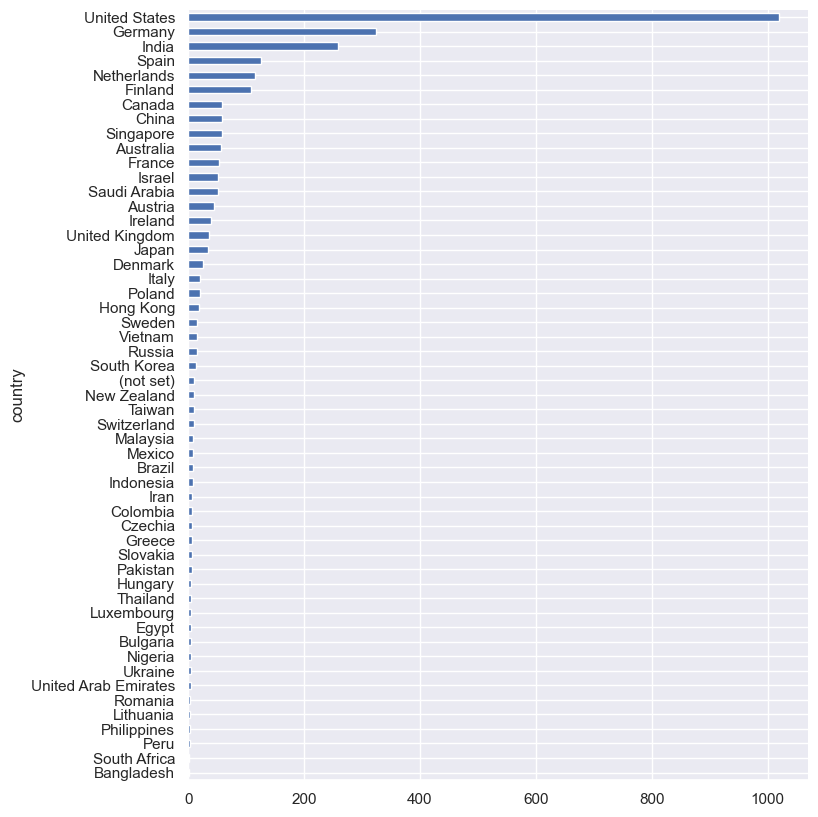

In [117]:
df.groupby('country').sessions.sum().sort_values(ascending=True).plot(kind='barh', figsize=(8, 10))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [43]:
page_view_df = df[df.eventName == 'page_view']

<Axes: ylabel='browser'>

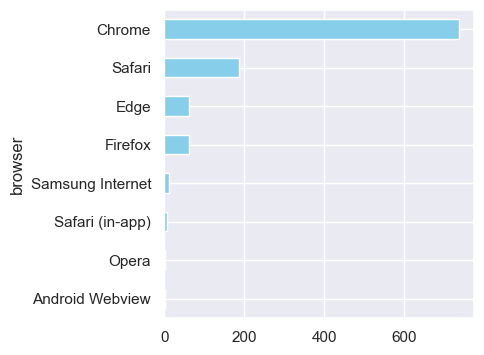

In [123]:
page_view_df.groupby([
    # 'deviceCategory',
    # 'city',
    # 'region',
    # 'country',
    'browser',
]).sessions.count().sort_values(ascending=True).plot(kind='barh', figsize=(4, 4), color='skyblue')